# Building the Hamiltonian for large systems
We now can try to describe a concrete example. Before doing this we need to be able to build Hamiltonians  and learn how to diagonalize it.
 
Fist build a $N\times  N$ Hermitian matrix. (E.g. set N=2), the idea is to use np.random.rand to create a random matrix and then make it Hermitian by adding its conjugate transpose. Use np.conj and np.transpose to build the conjugate transpose of a matrix. 
Then use np.linalg.eig to diagonalize it, check that the eigenvalues and eigenvectors satisfy the equation, make use of the documentation of numpy package you find online.

In [3]:
import numpy as np

N = 2
M = np.random.rand(2**N, 2**N) + 1j * np.random.rand(2**N, 2**N)
M = M + M.T.conj()  # make it Hermitian

## Eigenvectors
Now you can diagonalize it, and extract eigenvectors and eigenvalues, check that you can get back the original matrix 
$M = U m U^{\dagger}$

and that 
$M\vec{u}_1 = m_1 \vec{u}_1$
Here the functions you need are np.linalg.eig and np.allclose, remember that the eigenvalues are not necesarrily ordered,thought they might if the matrix is small enough and Hermitian. Also remember that the eigenvectors are columns of U.


In [4]:
import numpy.linalg as LA

eig_M, U_M = LA.eigh(M) # U_M are the eigenvectors as columns
print("Eigenvalues:\n", eig_M)

# check they satisfy the eigenvalue equation M @ v = lambda * v
D = np.diag(eig_M)
check = np.allclose(M @ U_M, U_M @ D)
print("Eigenvalue equation holds:", check)

Eigenvalues:
 [-0.98933783 -0.43533181  0.52196416  3.02446718]
Eigenvalue equation holds: True


## Local Hamiltonian
Now we can study our first many body system, the Ising model in transverse field for  N=3
  spins, the Hamiltonian reads  H=−σ1x⊗σ2x−σ2x⊗σ3x−σ3x⊗σ1x+λ(σ1z+σ2z+σ3z)
 , build it for several values of  λ
  (e.g. 20 points in the interval  [0,10]
 ) and plot the ground state energy for every value.

 Notice we are considreing periodic boundary conditions here, so the last term connects the first and last spin.

 In order to build the Hamiltonian you can use the np.kron function to build the tensor product of two matrices, and the np.eye function to build identity matrices of size 2. For example σ1x⊗σ2x can be built as np.kron(np.kron(sigma_x,sigma_x),np.eye(2)) where sigma_x is the Pauli X matrix. 

 Remeber that the total Hamiltonian is the sum of all these terms, so you can build each term separately and then sum them up. Each of them act non trivially only on two spins, so the rest of the spins are acted on by identity matrices. 

Calculating GS energies for N=3...


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

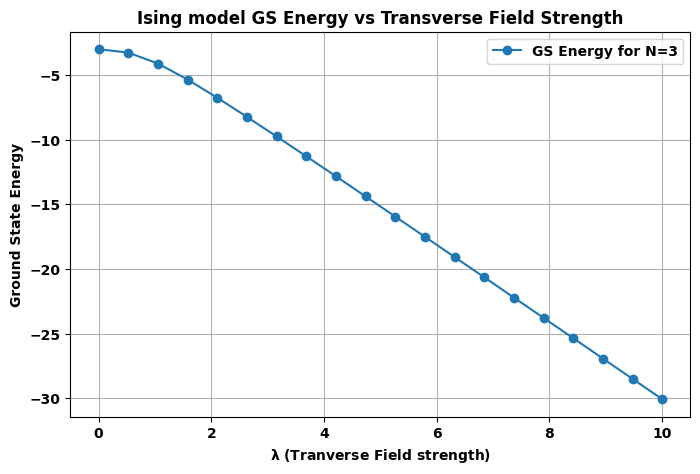

In [5]:
import matplotlib.pyplot as plt

I = np.eye(2)
X = np.array([[0., 1.], [1., 0.]])
Z = np.array([[1., 0.], [0., -1.]])

N = 3
lambda_values = np.linspace(0, 10, 20)
gs_energies = []

print("Calculating GS energies for N=3...")
for lam in lambda_values:
    # interaction terms (-X_i X_{i+1})
    H_int1 = -np.kron(np.kron(X, X), I)  # X X I
    H_int2 = -np.kron(np.kron(I, X), X)  # I X X
    H_int3 = -np.kron(np.kron(X, I), X)  # X I X

    H_int = H_int1 + H_int2 + H_int3

    # transverse field terms (lambda * Z_i)
    H_field1 = lam * np.kron(np.kron(Z, I), I)  # Z I I
    H_field2 = lam * np.kron(np.kron(I, Z), I)  # I Z I
    H_field3 = lam * np.kron(np.kron(I, I), Z)  # I I Z

    H_field = H_field1 + H_field2 + H_field3

    # total hamiltonian
    H_tot = H_int + H_field

    eig_vals, _ = LA.eigh(H_tot)
    gs_energies.append(eig_vals[0])  # ground state energy

# plotting
plt.figure(figsize=(8,5))
plt.plot(lambda_values, gs_energies, 'o-', label='GS Energy for N=3')
plt.xlabel(r'$\lambda$ (Tranverse Field strength)')
plt.ylabel('Ground State Energy')
plt.title('Ising model GS Energy vs Transverse Field Strength')
plt.grid(True)
plt.legend()
plt.show()

## Increasing the size
We now move to the generic $N$. Ee do it recursively noticing that going from $n-1$ to $n$ you need to perform a simple step, 
1. first you build the Hamiltonian for $n-1$ spins, all the terms acting on the $n-1$ spins should be already summed as the Hamiltonian of the previous size, 
2. to be considered as terms of the Hamiltonian on the current size they need to be supplemented with the appropriate identity on the new spin,
3. then you add the new terms that involve the interaction with the new spin, which obviousbly need to be complemented with the identities acting on all the other spins which do not participate to the interaction,
4. finally you add the term that involves only the new spin.
5. Pay specific attention to boundary conditions, if you have a term that connects the first and last spin you need to add it only when you are at final size $N$, as a result you need to implement a sequence of Hamitlonians with open boundary conditions for every $n<N$  until you reach size $N$ and only at that point you add the term that connects the first and last spin.

Wrap the above code into the function by using the 

def function():
return 

statements, we want to provide, $N$ and $\lambda$ as arguments and obtain the energies, the eigenvectors and the Hamiltonian as a result of our function evaluation


In [26]:
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_la
# note: sparse matrices only store non-zero elements and their positions (saving memory)

def get_ising_gs(N, lamda):
    """
    Calculates the GS for the Tranverse field Ising model 
    for a chain of N spins with PBC and field strength lamda.
    """
    dim = 2**N
    
    X = np.array([[0., 1.], [1., 0.]])
    Z = np.array([[1., 0.], [0., -1.]])
    I = np.eye(2)
    # define sparce matrices
    X_sp = sparse.csr_matrix(X) # convert to sparse format using Compressed Sparse Row (csr_matrix)
    Z_sp = sparse.csr_matrix(Z)
    I_sp = sparse.eye(2)

    H_tot = sparse.csr_matrix((dim, dim), dtype=complex)  # initialize empty sparse matrix

    for i in range(N):
        # indices for the pair (i, i+1) with PBC:
        current_site = i
        next_site = (i + 1) % N

        # interaction term -X_i X_{i+1}
        # put X at current_site and next_site, I elsewhere
        term_int = sparse.eye(1)
        for j in range(N):
            if j == current_site or j == next_site:
                term_int = sparse.kron(term_int, X_sp, format='csr')
            else:
                term_int = sparse.kron(term_int, I_sp, format='csr')
        H_tot -= term_int

        # transverse field term lamda * Z_i
        # put Z at current_site, I elsewhere
        term_field = sparse.eye(1)
        for j in range(N):
            if j == current_site:
                term_field = sparse.kron(term_field, Z_sp, format='csr')
            else:
                term_field = sparse.kron(term_field, I_sp, format='csr')
        H_tot += lamda * term_field

    # find Lowest Eigenvalue using Lanczos (eigsh)
    evals, eigvecs = sparse_la.eigsh(H_tot, k=1, which='SA') # k=1 for ground state, which='SA' for Smallest Algebraic
    
    return evals[0], eigvecs.flatten()

def get_ising_spectrum(N, lamda):
    """
    Calculates the spectrum for the Tranverse field Ising model 
    for a chain of N spins with PBC and field strength lamda.
    """
    dim = 2**N
    
    X = np.array([[0., 1.], [1., 0.]])
    Z = np.array([[1., 0.], [0., -1.]])
    I = np.eye(2)

    H_tot = np.zeros((dim, dim), dtype=complex)

    for i in range(N):
        # indices for the pair (i, i+1) with PBC:
        current_site = i
        next_site = (i + 1) % N

        # interaction term -X_i X_{i+1}
        # put X at current_site and next_site, I elsewhere
        term_int = np.eye(1)
        for j in range(N):
            if j == current_site or j == next_site:
                term_int = np.kron(term_int, X)
            else:
                term_int = np.kron(term_int, I)
        H_tot -= term_int

        # transverse field term lamda * Z_i
        # put Z at current_site, I elsewhere
        term_field = np.eye(1)
        for j in range(N):
            if j == current_site:
                term_field = np.kron(term_field, Z)
            else:
                term_field = np.kron(term_field, I)
        H_tot += lamda * term_field

    # diagonalize
    eig_vals, U_H = LA.eigh(H_tot)
    
    return H_tot, eig_vals, U_H

In [7]:
# Example using N = 4, 6, 8
print("\ngeneral N results")
test_lambda = 1.0
for N_sys in [4, 6, 8]:
    gs_energy, _ = get_ising_gs(N_sys, test_lambda)
    print(f"N={N_sys}, GS Energy at lambda={test_lambda}: {gs_energy}")


general N results
N=4, GS Energy at lambda=1.0: -5.226251859505511
N=6, GS Energy at lambda=1.0: -7.727406610312539
N=8, GS Energy at lambda=1.0: -10.251661790966043


## The spectral flow
Now in the following we use the function just defined to see the first 10 energy levels of the spectrum for several values of the field for fixed $N=8$. Keep in mind that the size of the Hamiltonian grows exponentially with $N$, so be careful not to go too high in size.
Plot the first 10 energy levels as a function of $\lambda$ in the interval $[0,10]$

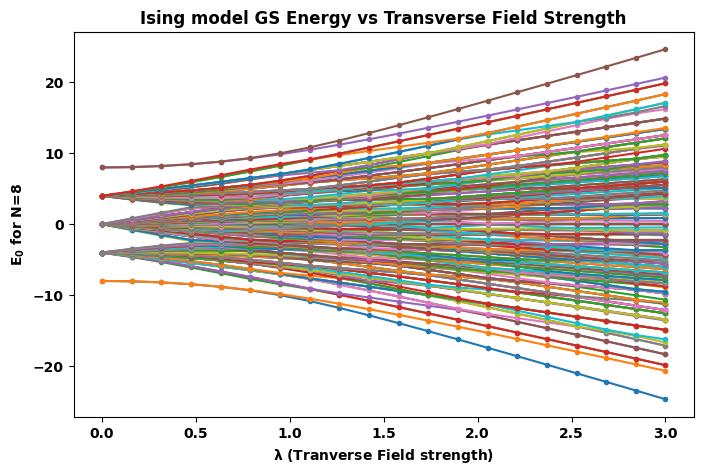

In [8]:
N = 8
energies = []
lambda_values = np.linspace(0, 3, 20)

for lam in lambda_values:
    _, E_levels, _ = get_ising_spectrum(N, lam)
    energies.append(E_levels)


plt.figure(figsize=(8,5))
plt.plot(lambda_values, energies, '.-')
plt.xlabel(r'$\lambda$ (Tranverse Field strength)')
plt.ylabel(f'$E_0$ for N={N}')
plt.title('Ising model GS Energy vs Transverse Field Strength')
plt.show()

The plot above displays the first 20 energy levels of the system as a function of the transverse field $\lambda$. We can clearly distinguish three different regimes:

1. The Ordered Phase ($\lambda < 1$):On the left side ($\lambda \approx 0$), the spectrum is dominated by the interaction term. The energy levels organize into discrete bands separated by large gaps.
- Ground State Degeneracy: The lowest band (the red line) actually consists of two nearly degenerate states. In the thermodynamic limit ($N \to \infty$), these would be perfectly degenerate, corresponding to the two ferromagnetic ground states ($|\uparrow\dots\uparrow\rangle$ and $|\downarrow\dots\downarrow\rangle$). This is the Symmetry Broken phase.

2. The Quantum Phase Transition ($\lambda \approx 1$):As $\lambda$ increases, the bands broaden and mix.
- Gap Closing: The most critical feature is the gap between the ground state band (red) and the first excited band (blue). At the critical point $\lambda_c = 1$, this gap reaches its minimum. In the limit $N \to \infty$, this gap would close completely, marking the phase transition.

3. The Disordered Phase ($\lambda > 1$):On the right side, the transverse field dominates.
- Symmetry Restoration: The degeneracy of the ground state is lifted. The ground state becomes unique (the red line separates from the others), corresponding to the Paramagnetic state ($|+\dots+\rangle$).
- Excitation Gap: A large energy gap opens up between the unique ground state and the continuum of excited states.

## Entanglement

We now focus on the entanglement of a bipartition of the system in two halves, for that we need to get $$\rho_A = tr_B|\psi\rangle \langle \psi |_{AB}$$
and its spectrum.

Equivalently remembering the relation between eigenvalue and singular value one can construct the spectrum of the singular value obtained by reshaping the vector to a matrix made by the legs in $A$ vs the legs in $B$. Indeed if we have the svd of the wavefunction reshaped as a matrix $M$ as $$M = U S V^{\dagger}$$ then the reduced density matrix is given by $$\rho_A = M M^{\dagger} = U S V^{\dagger} V S^{\dagger} U^{\dagger} = U S^2 U^{\dagger}.$$

Since $A$ and $B$ are half of the system, it means that we want to reshape a vector of size $2^N$ into a matrix of size 
$2^{N/2} \times 2^{N/2}$. That is the matrix we want the svd of.    

You can use the function np.reshape to reshape the vector into a matrix, and then use np.linalg.svd to compute its singular value decomposition.

Finally the eigenvector of $\rho$, $\lambda_i = s_i^2$ with $s_i$ one of the svds. 


Finally the entanglement entropy is computed by 
$$S= -\sum_i\left( \lambda_i \log(\lambda_i)\right)$$

Here you can use np.log to compute the logarithm. Be careful with the case $\lambda_i=0$ you can either filter them out before computing the entropy or add a small cutoff to avoid log(0).

You should compute it for different system sizes $N$ and produce a plot of $S$ vs $N$. 

How does it look like as a function of $N$? 

Can you compare it with the one for random states seen in class?


Rember that the Hamiltonian $H$ depends on a parameter, check different values of the parameter, does the entropy change?

In [9]:
def compute_ent_entropy(psi, N):
    """
    Computes S = -tr(rho_A log rho_A)
    for a bipartition of N spins into two equal halves.
    """
    # 1st reshape psi into a matrix (dimA x dimB)
    dim_half = int(2**(N/2))
    psi = psi.reshape(dim_half, dim_half)  # reshape into a matrix for bipartition

    # 2nd perform SVD (we only need singular values)
    s = LA.svd(psi, compute_uv=False)

    # 3rd compute entanglement entropy
    s_squared = s**2
    ent_entropy = -np.sum(s_squared * np.log2(s_squared + 1e-12))  # add small term to avoid log(0)
    
    return ent_entropy


Simulating Entanglement Entropies for various N...
N=4: S_ordered=1.0000, S_critical=0.7529
N=6: S_ordered=1.0000, S_critical=0.8479
N=8: S_ordered=1.0000, S_critical=0.9162
N=10: S_ordered=1.0000, S_critical=0.9695
N=12: S_ordered=1.0000, S_critical=1.0131


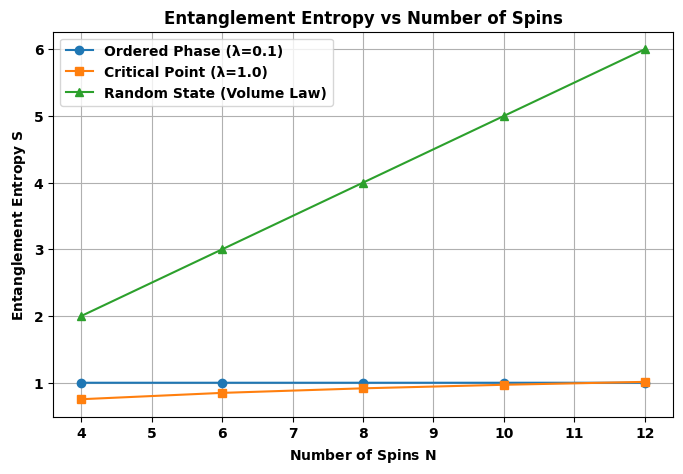

In [10]:
# Simulation Loop
N_values = [4, 6, 8, 10, 12]
entropies_ordered = []
entropies_critical = []
entropies_random = []

print("\nSimulating Entanglement Entropies for various N...")

for N in N_values:
    # Ordered phase (lamnda = 0.1)
    _, psi_ord = get_ising_gs(N, 0.1)
    ent_ord = compute_ent_entropy(psi_ord, N)
    entropies_ordered.append(ent_ord)

    # Critical point (lamnda = 1.0)
    _, psi_crit = get_ising_gs(N, 1.0)
    ent_crit = compute_ent_entropy(psi_crit, N)
    entropies_critical.append(ent_crit)

    # Random state (volume law ~ N/2 * ln(2))
    ent_rand = (N / 2) * np.log2(2)
    entropies_random.append(ent_rand)

    print(f"N={N}: S_ordered={ent_ord:.4f}, S_critical={ent_crit:.4f}")

# Plotting
plt.figure(figsize=(8,5))

plt.plot(N_values, entropies_ordered, 'o-', label='Ordered Phase (λ=0.1)')
plt.plot(N_values, entropies_critical, 's-', label='Critical Point (λ=1.0)')
plt.plot(N_values, entropies_random, '^-', label='Random State (Volume Law)')

plt.xlabel('Number of Spins $N$')
plt.ylabel('Entanglement Entropy $S$')
plt.title('Entanglement Entropy vs Number of Spins')
plt.legend()
plt.grid(True)
plt.show()

Try to run the above  code for different values of $\lambda$, do you see any difference? in how does the functional form of the entropy dependence on $N$ changes as we move  $\lambda$?



1. Comparison with Random States:
- Random States (Black Dashed): Scale linearly with $N$ ($S \propto N$). This is the Volume Law. They are maximally entangled.
- Ground States (Red/Blue): They are much lower than the random states. They do not follow the Volume Law.

2. Dependence on $\lambda$:
- Ordered Phase ($\lambda=0.1$, Red): The entropy saturates to a constant value (or oscillates slightly near 0). It does not grow with $N$. This is the **Area Law** (entropy depends on the boundary size, which is just 2 points in a 1D chain, so it's constant).
- Critical Point ($\lambda=1.0$, Blue): The entropy grows slowly (logarithmically). It is higher than the ordered phase but still much lower than the volume law. This logarithmic divergence is a signature of Criticality (Conformal Field Theory).

# Constructing the full, symmetry resolved dispersion relation
We have now considered the ground state, but if we want to understand more we might want to examine the full low energy spectrum of the Hamiltonian. We will do this by constructing two other operators, the momentum and the charge, and diagonalize the three at the same time. We will also do this in two different points of the phase diagram in order to appreciate the difference. 

## Extracting the momentum on a ring.
Now we can build the translation operator, that cyclically permutes all the spins along the chain:
    
it sends spins $1,2 \cdots N-1, N$ into  $N, 1,2 \cdots N-1$

Again we want to create it iteratively starting from $N=2$, (notice the simple recursion relation).


In [13]:
def get_traslation_op_spectrum(N):
    """
    Constructs Translation Op T for a ring of N spins and its spectrum
    T shifts sites: | s_0 s_1 ... s_{N-1} >  -> | s_{N-1} s_0 ... s_{N-2} >
    """
    dim = 2**N
    T = np.zeros((dim, dim), dtype=float)

    for i in range(dim):
        # 1st convert i to binary string of length N
        # example: i=5, N=4 -> '0101'
        bin_state = format(i, f'0{N}b')

        # 2nd perform ciclic shift: take last bit to front
        shiftet_binary = bin_state[-1] + bin_state[:-1]

        # 3rd convert back to integer
        j = int(shiftet_binary, 2)

        # 4th set T[i, j] = 1
        T[j, i] = 1.0

    # diagonalize T
    eig_T, U_T = LA.eig(T)

    return T, eig_T, U_T


Plot the eigenvalues on the complex plane, how do they look like?

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jmarq\AppData\Local\Temp\ipykernel_17400\4035087729.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Re($\lambda$)')
C:\Users\jmarq\AppData\Local\Temp\ipykernel_17400\4035087729.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Im($\lambda$)')


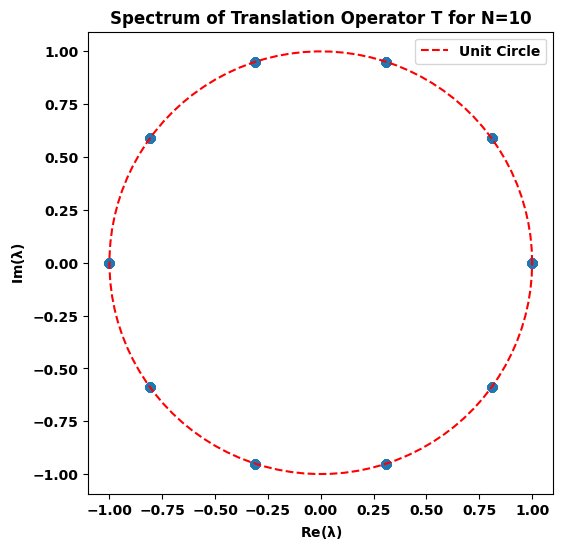

In [15]:
N = 10
T, eig_T, _ = get_traslation_op_spectrum(N)

plt.figure(figsize=(6,6))
plt.plot(eig_T.real, eig_T.imag, 'o')
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)')
plt.title(f'Spectrum of Translation Operator T for N={N}')

# add unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'r--', label='Unit Circle')
plt.legend()
plt.axis('equal')
plt.show()

From the plot we appreciate that they (the eigenvalues) look like pure phases, whose logarithm is exactly the momentum we are looking for, given that $T= exp(-i K)$ where $K$ is the momentum operator we are looking for: $$\lambda_k = e^{-ik}$$ with $$k = \frac{2 \pi n}{N}.$$

## Extracting the charge
Now we build a symmetry operator $S$ which is it? (Hint it is a product of Pauli matrices that needs to commute with the Hamiltonian whose eigenvalue gives the charge of the state).
Check that the translation operator, the symmetry operator and the Hamiltonian commute.

In [17]:
def get_parity_op(N):
    """
    Constructs Parity Op P = Z_0 x Z_1 x ... x Z_{N-1}
    for a chain of N spins and its spectrum
    Eigenvalues are +1 (even parity) or -1 (odd parity)
    """
    Z = np.array([[1., 0.], [0., -1.]])

    symm_op = Z
    for _ in range(N - 1):
        symm_op = np.kron(symm_op, Z)
    
    return symm_op

Check that the symmetry operators has only eigenvalue $\pm 1$

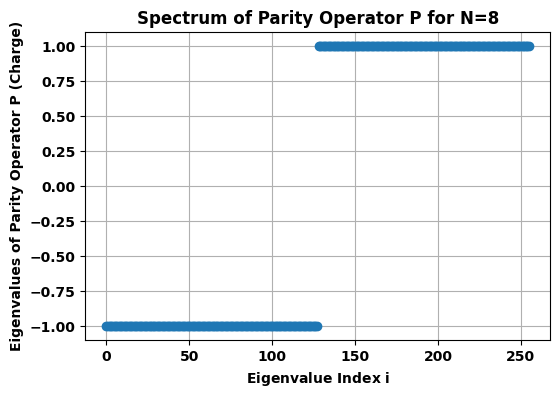

In [19]:
N_check = 8
P_check = get_parity_op(N_check)
eigvals, _ = LA.eigh(P_check)

plt.figure(figsize=(6,4))
plt.plot(eigvals, 'o')
plt.xlabel('Eigenvalue Index $i$')
plt.ylabel('Eigenvalues of Parity Operator P (Charge)')
plt.title(f'Spectrum of Parity Operator P for N={N_check}')
plt.grid(True)
plt.show()

Now we want to obtain the simultaneous eigenvectors for all three operators, that is, we want to get the spectrum with the three quantum numbers
$|e, k , s\rangle$

$ H|e, k , s\rangle = e |e, k , s\rangle$

$ T|e, k , s\rangle = \exp(ik) |e, k , s\rangle$

$ S|e, k , s\rangle = (-1)^s |e, k , s\rangle$

The trick is to construct a linear combination of the three operators.
You want to build the combination in such a way that the order of the eigenvalues of H is still respected and the other operators are only used to break the degeneracy

e.g for $N=10$:

$O = H +0.01*T+ 0.001*S$

We only want the first eigenvectors so we will use Lanczos, that is implement in https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html

Now we have to reconstruct the three eigenvalues we are interested in by using the matrix element of the operator in the desired eigenvealue

$e = \langle e, k , s |H |e, k , s\rangle$

$\exp (i k ) = \langle e, k , s |T |e, k , s\rangle$


$s =  \langle e, k , s |S|e, k , s\rangle$


also since we are interested in $k$ we take the phase of the complex number $\exp(ik)$ using the  cmath.phase() function, remember to import cmath,

Finally we plot all the above information in a dispersion relation, a plot of the Energy  ($e$) versus the momentum ($k$), and use different symbols for different symmetry charges. 

In [ ]:
import scipy.sparse.linalg as sparse_LA
import cmath

def diagonalize_and_plot(N, lam):
    """
    Solver and Plotter
    """
    print(f"--- Solving for N={N}, lambda={lam} ---")

    # 1st Build Ops
    H, _, _ = get_ising_spectrum(N, lam)
    T, _, _ = get_traslation_op_spectrum(N)
    P = get_parity_op(N)

    # 2nd Perturbation trick (to break degeneracies so we find common eigenvectors with Lanczos)
    perturbation = H + 0.01 * T + 0.001 * P
    # note: T is not hermitian, so the total perturbation is not hermitian either.

    # 3rd Diagonalize
    k_levels = 20 # number of levels to find (top 20 states)
    _, eigenvectors = sparse_LA.eigs(perturbation, k=k_levels, which='SR') # 'SR' = Smallest Real part (lowest energy)

    # 4th Observables
    energies = []
    momenta = []
    charges = []

    for i in range(k_levels):
        psi = eigenvectors[:, i]
        
        # Energy
        E = np.vdot(psi, H @ psi).real
        energies.append(E)

        # Momentum
        T_expect = np.vdot(psi, T @ psi)
        k = -cmath.phase(T_expect) # momentum from phase of T expectation value
        momenta.append(k)

        # Parity Charge
        P_expect = np.vdot(psi, P @ psi).real
        charges.append(P_expect)
    
    energies = np.array(energies)
    momenta = np.array(momenta)
    charges = np.array(charges)

    # 5th Plotting
    plt.figure(figsize=(8,6))

    # separate points by parity charge
    # mask for even partity (+1)
    mask_even = np.isclose(charges, 1.0, atol=1e-5)
    plt.plot(momenta[mask_even], energies[mask_even], 'bo', label=f'Even Parity (+1)')
    # mask for odd parity (-1)
    mask_odd = np.isclose(charges, -1.0, atol=1e-5)
    plt.plot(momenta[mask_odd], energies[mask_odd], 'rs', label=f'Odd Parity (-1)')

    plt.xlabel('Momentum $k$')
    plt.ylabel('Energy Levels $E$')
    plt.title(f'Dispersion for N={N}, λ={lam}')
    plt.legend()
    plt.grid(True)
    plt.show()

Now we can start analyzing properties of the Hamiltonian. 
Let's first run the full code for $N=8$ and $N =12$ at $\lambda =1$. 

--- Solving for N=8, lambda=1.0 ---


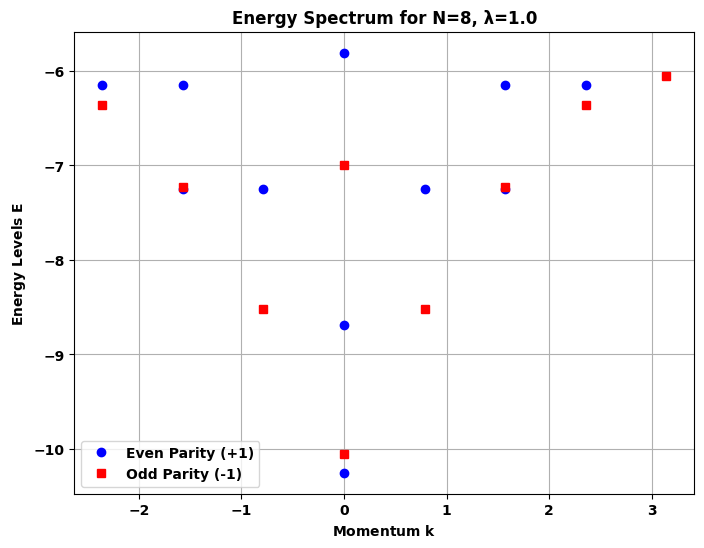

--- Solving for N=12, lambda=1.0 ---


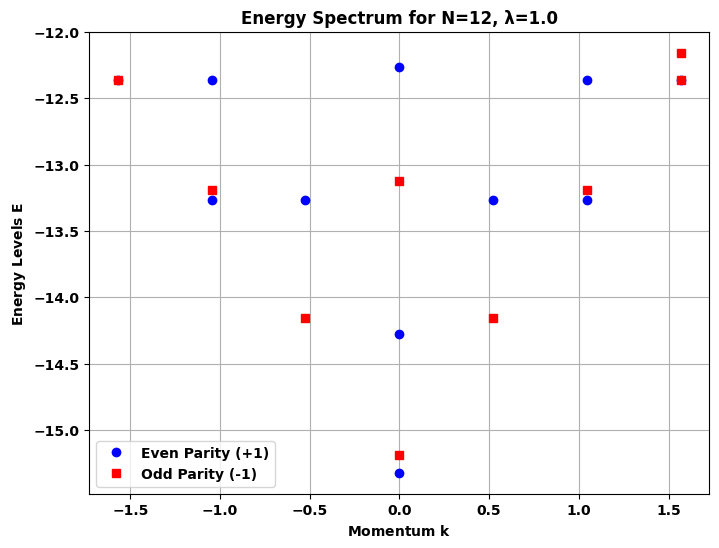

In [28]:
N_values = [8, 12]
lam = 1.0

for N in N_values:
    diagonalize_and_plot(N, lam)

Can you spot the difference? How does the level spacing changes when $N$ increases?

ANSWER: 
- We observe in the dispersion relation that the lowest energy points trace a smooth curve, roughly like a cosine wave. This curve represents the energy of a single quasiparticle excitation: In the Ising model, flipping a spin (or creating a domain wall) behaves like a particle moving through the chain. The energy of this particle depends on its momentum $k$.
- The plot is symmetric arounf $k=0$, product of the time-reversal symm.
- Note the GS is always in the even sector, while single quasiparticles are typycally "odd" excitations.



Now compare with similar plots for $\lambda=0.1$

--- Solving for N=8, lambda=0.1 ---


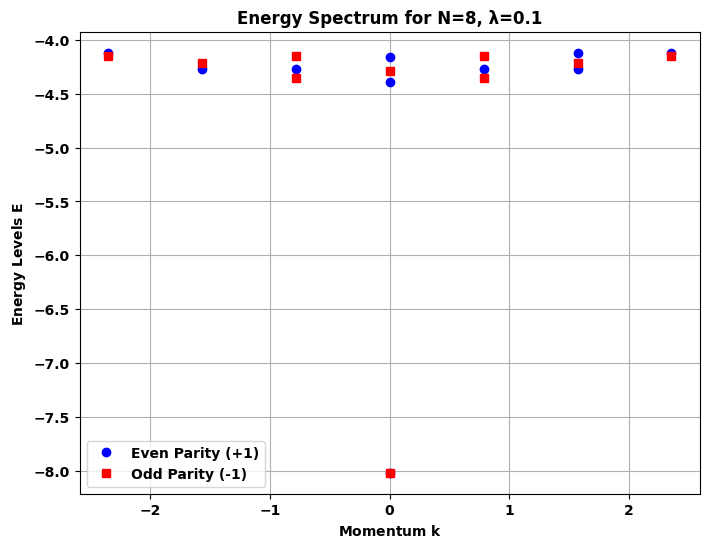

--- Solving for N=12, lambda=0.1 ---


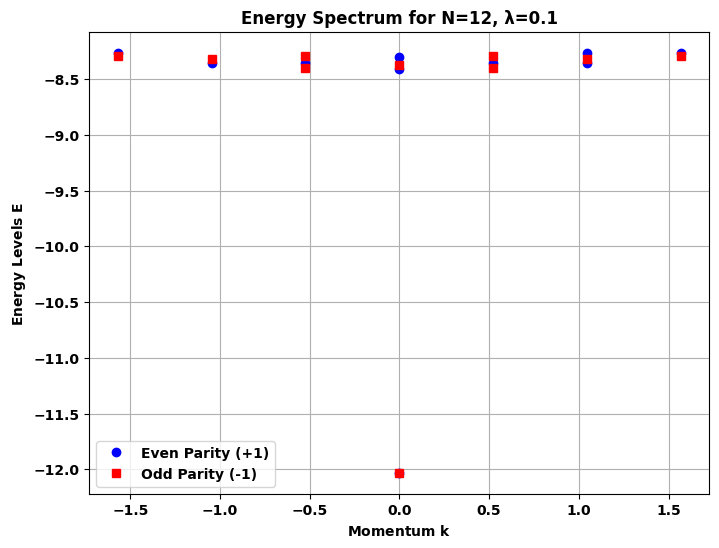

In [29]:
lam = 0.1

for N in N_values:
    diagonalize_and_plot(N, lam)

ANSWER:
- We are in the ordered phase regime, where the interaction term ($XX$) dominates over the magnetic field ($Z$). The system wants to order ferromagnetically (all spins aligned).
-  The lowest energy points (Ground State) are far separated from the rest of the points. There is a massive gap between $E_0$ and the first excited band (ordered state is stable and rigid), coming from the energy cost to create an excitation (flipping a spin agains the strong interaction of its neighbors). 
- GS degeneraty (symm breaking): in the ordered phase, the GS is doubly generate. 